In [1]:
!pip install nilearn pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 97.9 MB/s eta 0:00:00


In [2]:
import cv2
import pdb
import os
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import ipywidgets as widgets
import scipy.signal, scipy.misc
import plotly.graph_objects as go
import random
import base64
import io

from ipywidgets import interact, IntSlider, FloatSlider
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting, datasets, image, regions
from nilearn.connectome import ConnectivityMeasure
from nilearn.decoding import Decoder
from nilearn.image import mean_img, index_img
from nilearn.datasets import MNI152_FILE_PATH, load_mni152_template
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_glass_brain, view_img_on_surf, plot_epi, show, plot_roi, view_img
from nibabel.testing import data_path
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.model_selection import LeaveOneGroupOut
from skimage import data
from skimage.color import rgb2gray
from math import *
from pathlib import Path
from PIL import Image

import torch
import torch.fft as fft
import torch.nn.functional as F
import math
from torch import nn
from torch.utils.data import DataLoader
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from scipy.ndimage import gaussian_filter
from google.colab import drive
from torch.utils.data import Dataset


/tmp/ipython-input-3869109805.py:10: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.signal, scipy.misc


In [3]:
drive.mount('/content/drive')
!mkdir -p /content/data
!cp -r /content/drive/MyDrive/mri_data/train/ /content/data/train
!cp -r /content/drive/MyDrive/mri_data/test/ /content/data/test

Mounted at /content/drive


In [4]:
train_data_path = "/content/data/train"
test_data_path = "/content/data/test"
import os

train_data_pair_paths = []

for i in range(18):
    lf = os.path.join(
        train_data_path,
        "low_field",
        f"sample_{i+1:03d}_lowfield.nii"
    )

    hf = os.path.join(
        train_data_path,
        "high_field",
        f"sample_{i+1:03d}_highfield.nii"
    )

    train_data_pair_paths.append([lf, hf])

# for lf, hf in train_data_pair_paths:
#     print(os.path.exists(lf), os.path.exists(hf))

In [5]:
def ensure_3d(volume):
    if volume.ndim == 4:
        return volume[..., 0]
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D or 4D volume, got {volume.shape}")
    return volume


def plot_fractional_slices(volume, title, fractions=(0.25, 0.5, 0.75), cmap="gray"):
    """
    Plot axial slices at given fractional depths along Z-axis.
    """
    volume = ensure_3d(volume)
    z_dim = volume.shape[2]

    slice_indices = [int(f * (z_dim - 1)) for f in fractions]

    fig, axes = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 5))

    if len(slice_indices) == 1:
        axes = [axes]

    for ax, z in zip(axes, slice_indices):
        ax.imshow(volume[:, :, z], cmap=cmap)
        ax.set_title(f"{title}\nSlice z={z}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()



Selected brains: [17, 15, 14]


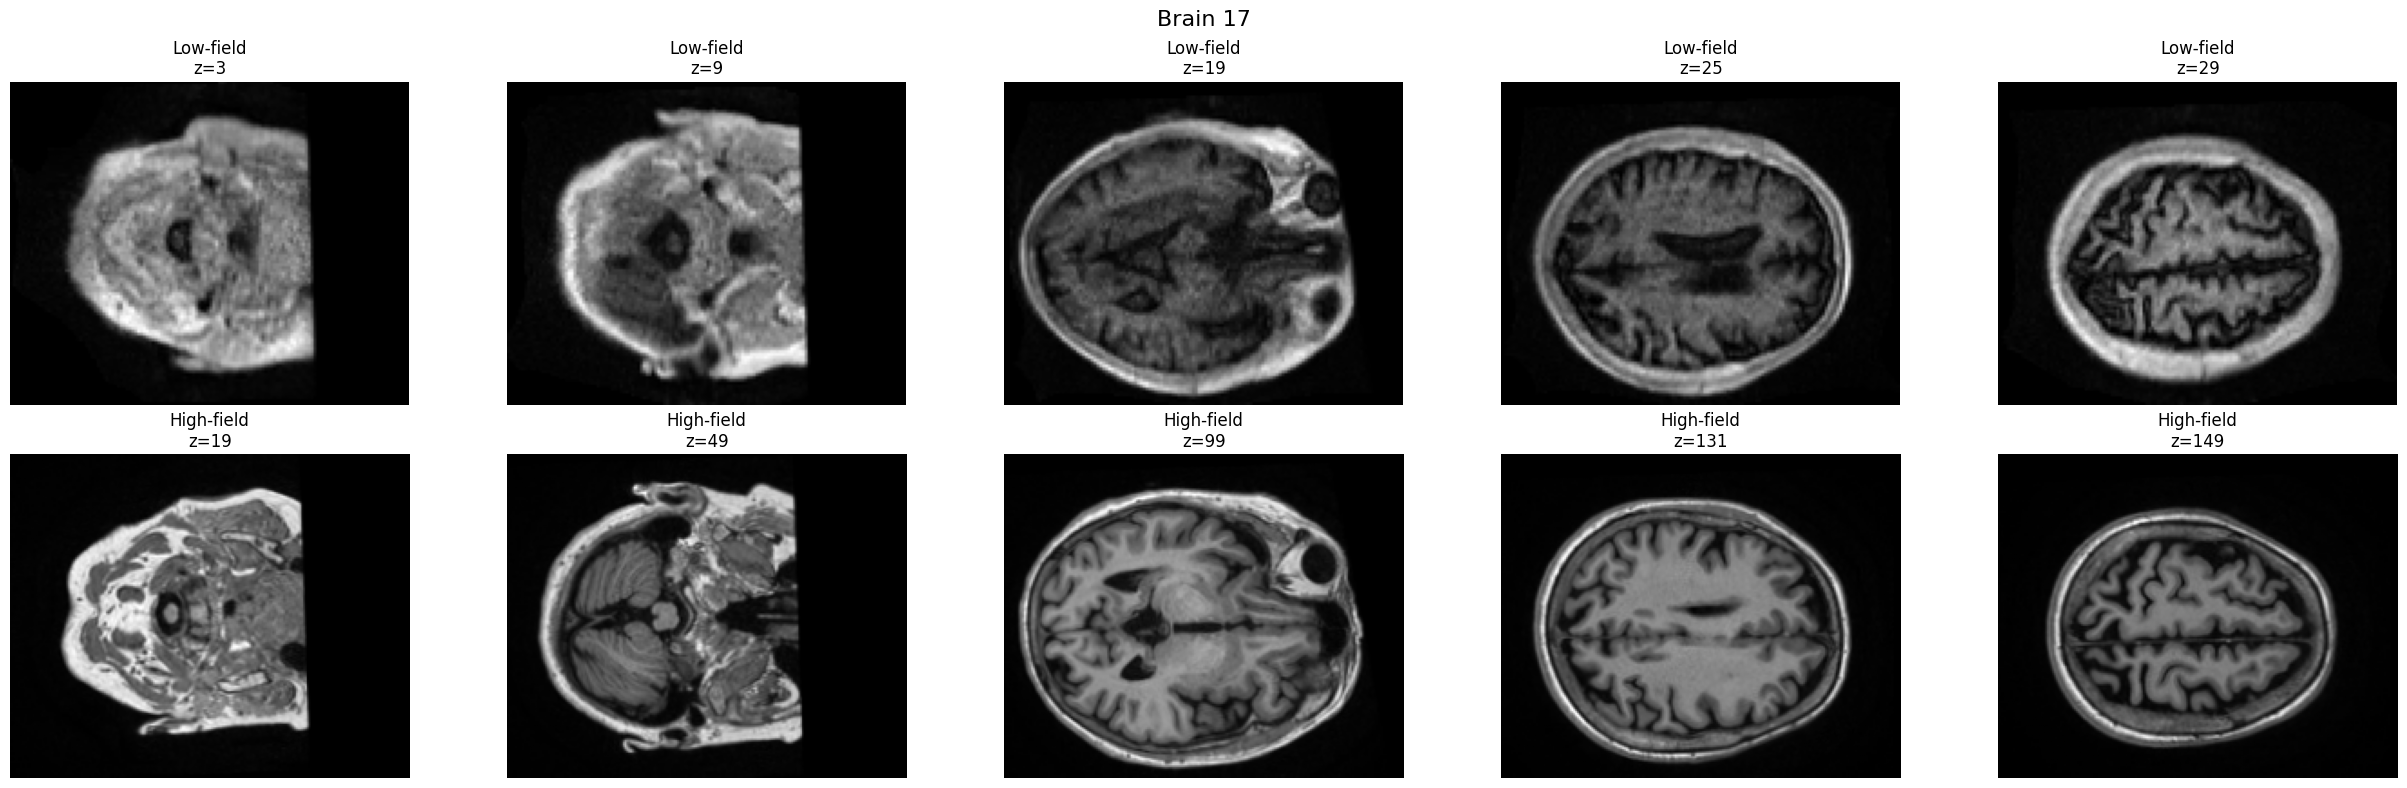

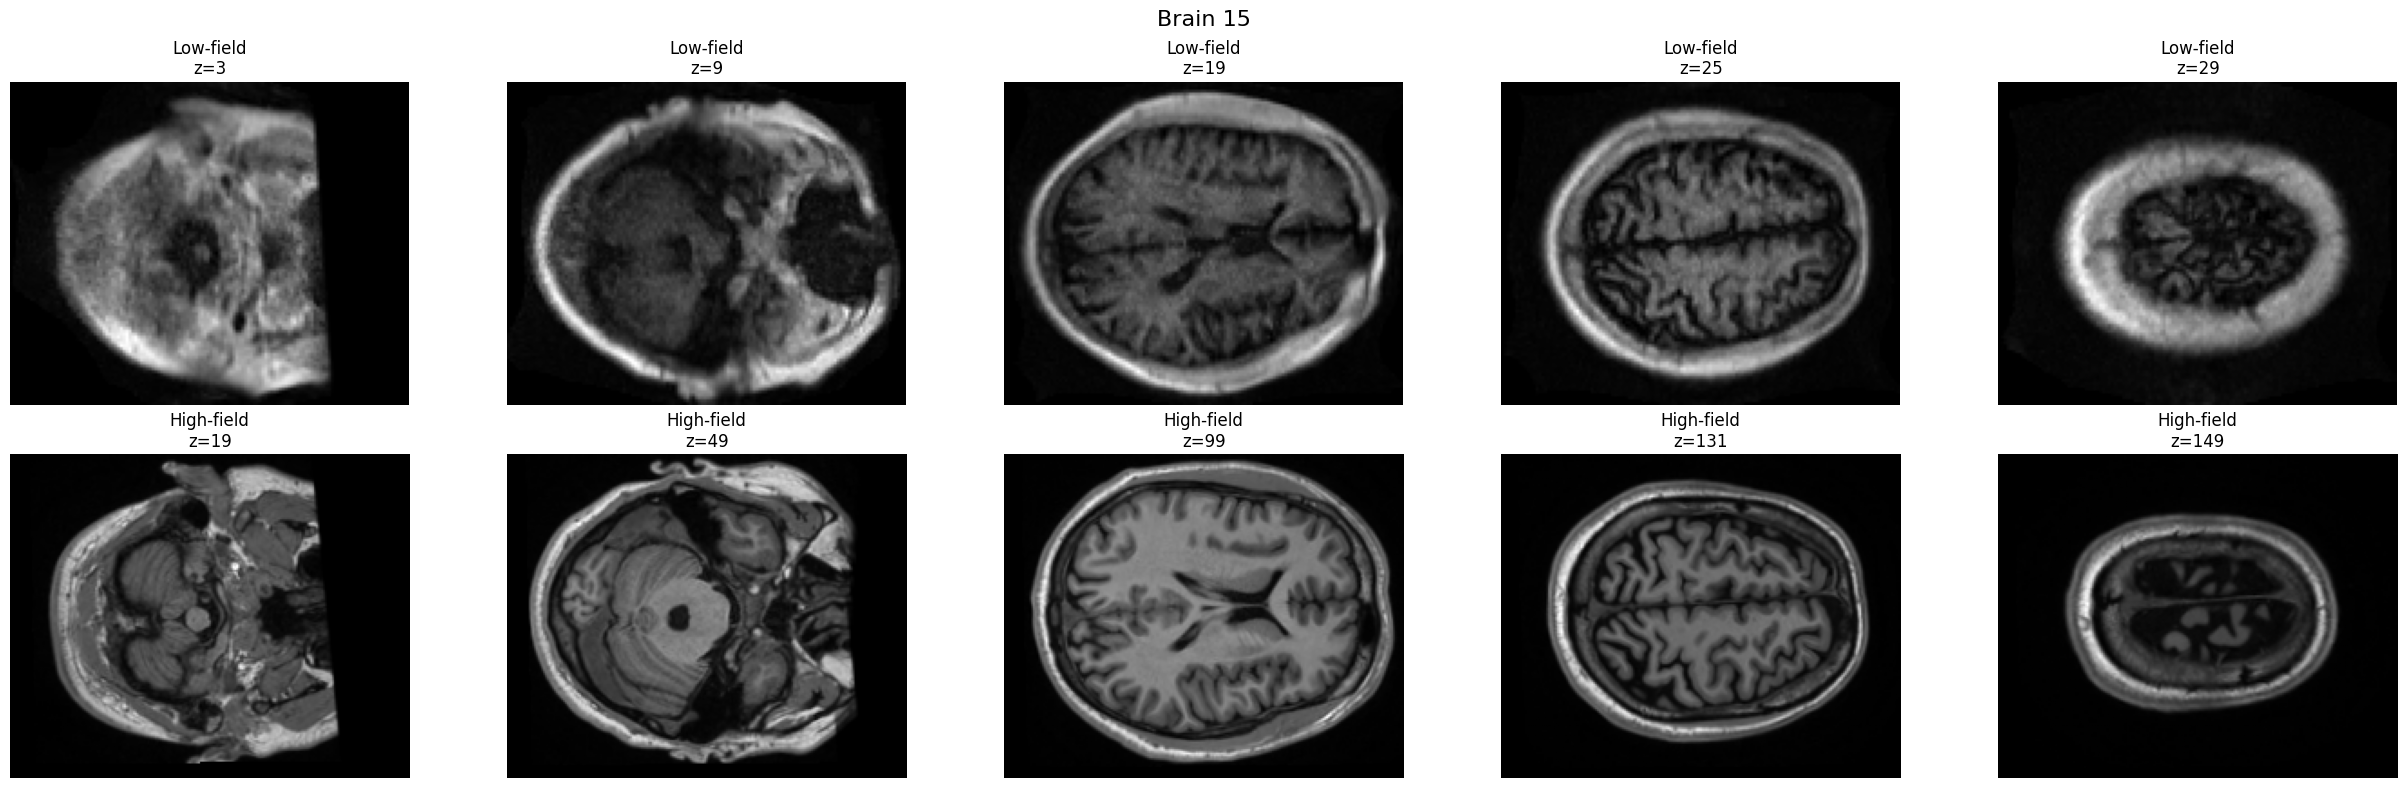

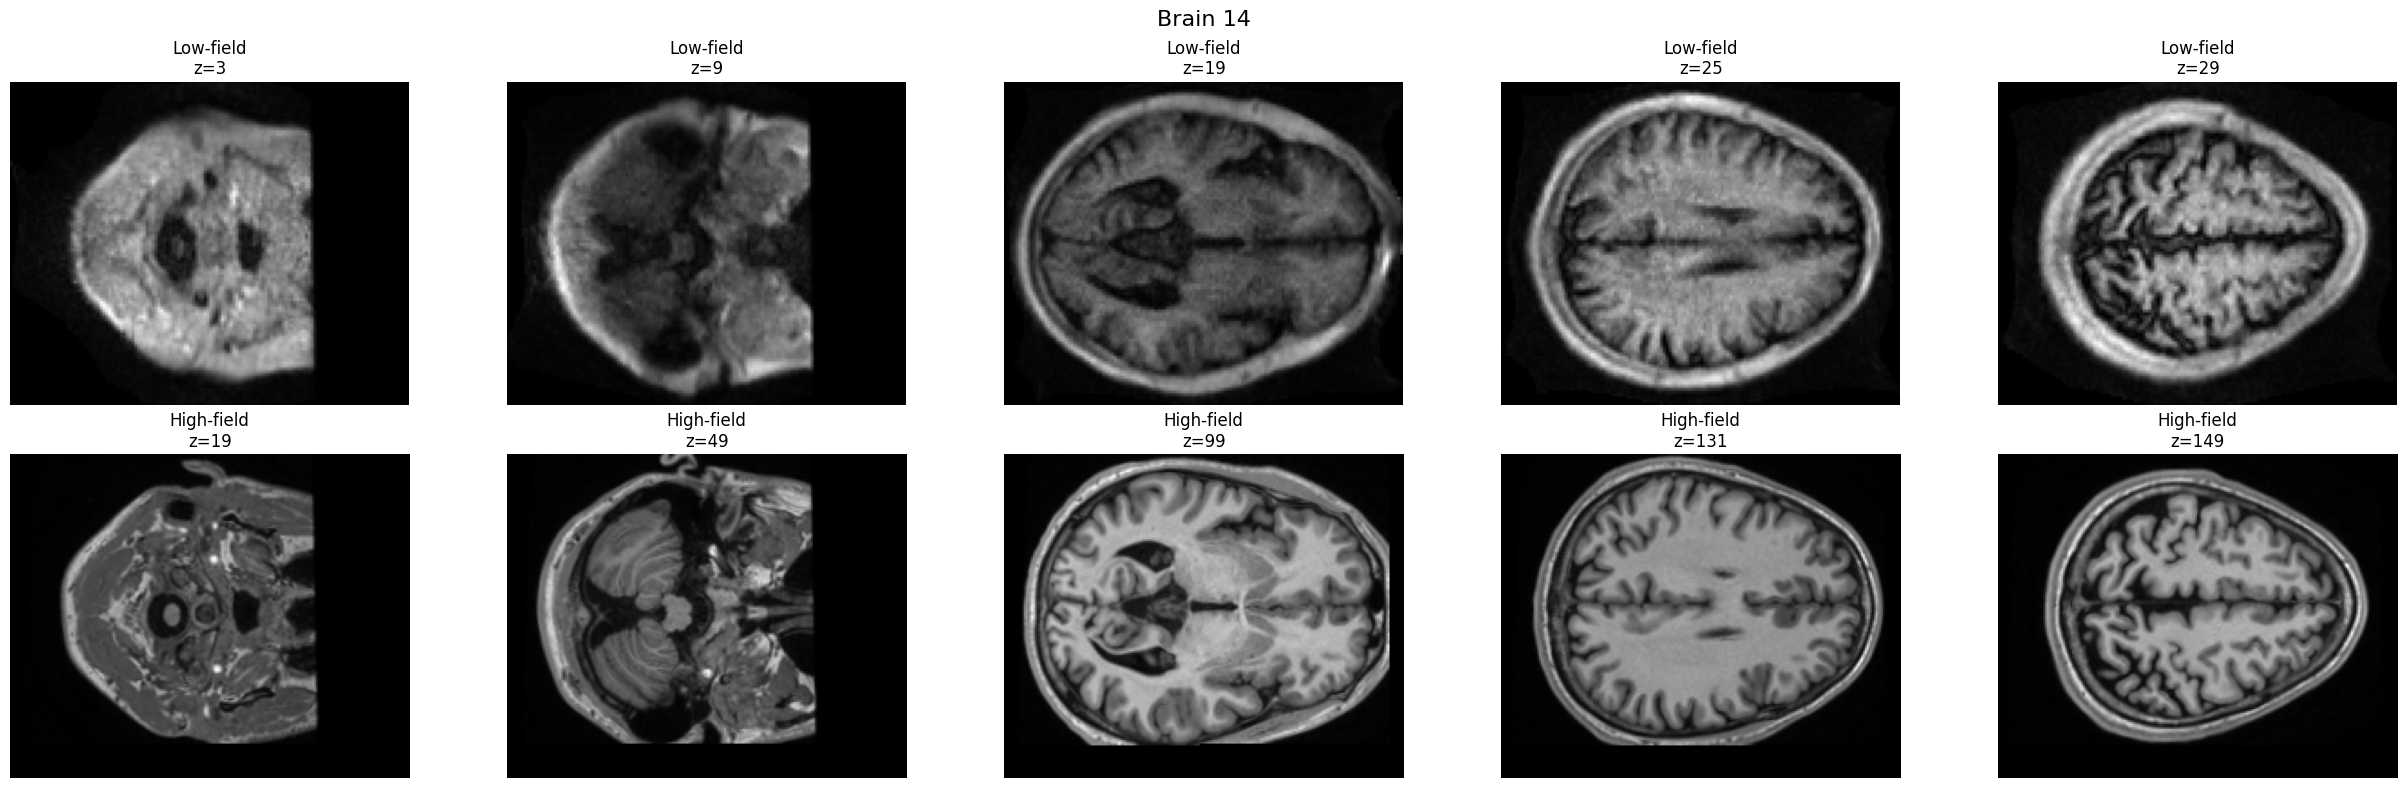

In [6]:
def plot_fractional_slices_pair(low, high, brain_id, fractions=(0.1, 0.25, 0.5, 0.66, 0.75)):
    low = ensure_3d(low)
    high = ensure_3d(high)

    zl = low.shape[2]
    zh = high.shape[2]

    low_idxs  = [int(f * (zl - 1)) for f in fractions]
    high_idxs = [int(f * (zh - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, (lz, hz) in enumerate(zip(low_idxs, high_idxs)):
        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(high[:, :, hz], cmap="gray")
        axes[1, j].set_title(f"High-field\nz={hz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id:02d}", fontsize=16)
    plt.tight_layout()
    plt.show()


selected_indices = random.sample(range(len(train_data_pair_paths)), 3)

print("Selected brains:", [i + 1 for i in selected_indices])

for i in selected_indices:
    low_path, high_path = train_data_pair_paths[i]

    img_low = nib.load(low_path)
    img_high = nib.load(high_path)

    plot_fractional_slices_pair(
        img_low.get_fdata(),
        img_high.get_fdata(),
        brain_id=i + 1
    )

In [7]:
def lowpass_mask(shape, cutoff):
    H, W = shape
    y = torch.linspace(-0.5, 0.5, H)
    x = torch.linspace(-0.5, 0.5, W)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= cutoff).float()

def add_rician_noise(x, sigma):
    noise_real = torch.randn_like(x) * sigma
    noise_imag = torch.randn_like(x) * sigma
    return torch.sqrt((x + noise_real)**2 + noise_imag**2)

def degrade(x_hr, scale=2, cutoff=0.25, noise_sigma=0.01):
    # FFT
    X = fft.fftshift(fft.fft2(x_hr))

    # Low-pass filter
    mask = lowpass_mask(X.shape[-2:], cutoff).to(X.device)
    X = X * mask

    # Back to image
    x_lp = fft.ifft2(fft.ifftshift(X)).real

    # Downsample
    x_lr = F.avg_pool2d(x_lp, kernel_size=scale)

    # Add Rician noise
    x_lr = add_rician_noise(x_lr, noise_sigma)

    return x_lr

def safe_residual(residual, cutoff):
    R = fft.fftshift(fft.fft2(residual))
    mask = lowpass_mask(R.shape[-2:], cutoff).to(R.device)
    R = R * mask
    return fft.ifft2(fft.ifftshift(R)).real

# def reconstruct(model, y_lr, scale=2, cutoff=0.25):
#     y_up = F.interpolate(y_lr, scale_factor=scale, mode='bilinear', align_corners=False)
#     r = model(y_up)
#     r_safe = safe_residual(r, cutoff)
#     return y_up + r_safe

def reconstruct(model, y_lr, out_size, cutoff=0.25):
    y_up = F.interpolate(
        y_lr,
        size=out_size,
        mode='bilinear',
        align_corners=False
    )

    r = model(y_up)
    r_safe = safe_lowpass(r, cutoff)

    return y_up + r_safe

def tv_loss(x):
    dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
    dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
    return dx.mean() + dy.mean()

def physics_loss(x_hat, y_lr, lam=0.01):
    y_hat = degrade(x_hat)
    dc = F.mse_loss(y_hat, y_lr)
    tv = tv_loss(x_hat)
    return dc + lam * tv

def load_nii(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data.astype(np.float32)

def reconstruct_slice(model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].to(device)  # [1,1,H,W]
    with torch.no_grad():
        x_hat = reconstruct(model, x)
    return x_hat.squeeze().cpu().numpy()

def psnr(x, y):
    mse = F.mse_loss(x, y)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def ssim_metric(x, y):
    return ssim(x, y, data_range=1.0, size_average=True)

def normalize(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)


def get_slice(vol, idx):
    return vol[:, :, idx]

In [8]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class LatentEncoder(nn.Module):
  def __init__(self, in_ch, latent_dim=8):
      super().__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_ch, 32, 3, padding=1),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d(1)
      )
      self.fc_mu = nn.Linear(32, latent_dim)
      self.fc_logvar = nn.Linear(32, latent_dim)

  def forward(self, x):
      h = self.conv(x).view(x.size(0), -1)
      mu = self.fc_mu(h)
      logvar = self.fc_logvar(h)
      return mu, logvar

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

def center_crop(enc, dec):
    _, _, H, W = dec.shape
    enc_H, enc_W = enc.shape[2], enc.shape[3]

    start_y = (enc_H - H) // 2
    start_x = (enc_W - W) // 2

    return enc[:, :, start_y:start_y+H, start_x:start_x+W]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# =========================
# Utility: Load + Normalize NIfTI
# =========================
def load_nii(path):
    nii = nib.load(path)
    data = nii.get_fdata().astype(np.float32)
    return data

def normalize_mri(vol):
    p1, p99 = np.percentile(vol, (1, 99))
    vol = np.clip(vol, p1, p99)
    vol = (vol - p1) / (p99 - p1 + 1e-6)
    return vol.astype(np.float32)   # ← critical line

# =========================
# Slice index mapping (40 → 200)
# =========================
def map_lr_to_hr_slice(k, lr_slices=40, hr_slices=200):
    return int((k / lr_slices) * hr_slices)

# =========================
# Dataset (2D axial slices)
# =========================
class MRINiftiSliceDataset(Dataset):
    def __init__(self, pair_paths):
        """
        pair_paths: list of [low_field_path, high_field_path]
        """
        self.samples = []

        for lf_path, hf_path in pair_paths:
            lr_vol = normalize_mri(load_nii(lf_path))
            hr_vol = normalize_mri(load_nii(hf_path))

            assert lr_vol.ndim == 3
            assert hr_vol.ndim == 3

            for k in range(lr_vol.shape[2]):
                z_hr = map_lr_to_hr_slice(k)
                self.samples.append((
                    lr_vol[:, :, k],
                    hr_vol[:, :, z_hr]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        y_lr, x_hr = self.samples[idx]
        return (
            torch.from_numpy(y_lr).unsqueeze(0),  # [1, H, W]
            torch.from_numpy(x_hr).unsqueeze(0)
        )

# =========================
# Frequency Utilities
# =========================
def lowpass_mask(shape, cutoff):
    H, W = shape
    y = torch.linspace(-0.5, 0.5, H, device=device)
    x = torch.linspace(-0.5, 0.5, W, device=device)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    R = torch.sqrt(X**2 + Y**2)
    return (R <= cutoff).float()

def safe_lowpass(x, cutoff):
    X = fft.fftshift(fft.fft2(x))
    mask = lowpass_mask(X.shape[-2:], cutoff)
    X = X * mask
    return fft.ifft2(fft.ifftshift(X)).real

# =========================
# Physics Degradation (x–y only)
# =========================
def degrade_xy(x_hat, y_lr, cutoff=0.35, noise_sigma=0.01):
    # Low-pass in Fourier domain
    X = fft.fftshift(fft.fft2(x_hat))
    mask = lowpass_mask(X.shape[-2:], cutoff)
    X = X * mask
    x_lp = fft.ifft2(fft.ifftshift(X)).real

    # Downsample EXACTLY to low-field shape
    x_lr = F.interpolate(
        x_lp,
        size=y_lr.shape[-2:],
        mode="bilinear",
        align_corners=False
    )

    # Rician noise
    n1 = torch.randn_like(x_lr) * noise_sigma
    n2 = torch.randn_like(x_lr) * noise_sigma
    return torch.sqrt((x_lr + n1) ** 2 + n2 ** 2)


# # =========================
# # Physics-Constrained CNN
# # =========================
# class PhysicsCNN(nn.Module):
#     def __init__(self, features=64, blocks=5, dropout=0.2):
#         super().__init__()
#         self.head = nn.Conv2d(1, features, 3, padding=1)
#         self.body = nn.Sequential(*[
#             nn.Sequential(
#                 nn.Conv2d(features, features, 3, padding=1),
#                 nn.ReLU(inplace=True),
#                 nn.Dropout2d(p=dropout)
#             ) for _ in range(blocks)
#         ])
#         self.tail = nn.Conv2d(features, 1, 3, padding=1)

#     def forward(self, x):
#         f = self.head(x)
#         r = self.body(f)
#         return self.tail(r)

# # =========================
# # PHYSICS UNET
# # =========================

class PhysicsUNet(nn.Module):
    def __init__(self, base_ch=32, dropout=0.2):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(1, base_ch)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(base_ch, base_ch * 2)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_ch * 2, base_ch * 4)

        # Decoder
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec2 = DoubleConv(base_ch * 4, base_ch * 2)

        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec1 = DoubleConv(base_ch * 2, base_ch)

        # Output
        self.dropout = nn.Dropout2d(p=dropout)
        self.out = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))

        # Bottleneck
        b = self.bottleneck(self.pool2(e2))

        # Decoder
        d2 = self.up2(b)
        e2_crop = center_crop(e2, d2)
        d2 = torch.cat([d2, e2_crop], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1_crop = center_crop(e1, d1)
        d1 = torch.cat([d1, e1_crop], dim=1)
        d1 = self.dec1(d1)

        d1 = self.dropout(d1)
        out = self.out(d1)

        # Force same spatial size as input
        if out.shape[-2:] != x.shape[-2:]:
            out = F.interpolate(
                out,
                size=x.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

        return out

# =========================
# Reconstruction
# =========================
def reconstruct(model, y_lr, out_size=(179, 221), cutoff=0.35):
    y_up = F.interpolate(y_lr, size=out_size, mode="bilinear", align_corners=False)
    r = model(y_up)
    r_safe = safe_lowpass(r, cutoff)
    return y_up + r_safe

# =========================
# Total Variation Loss
# =========================
def tv_loss(x):
    dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
    dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
    return dx.mean() + dy.mean()

# =========================
# Physics Loss
# =========================
def physics_loss(x_hat, y_lr, lam=0.01):
    y_hat = degrade_xy(x_hat, y_lr)
    dc = F.mse_loss(y_hat, y_lr)
    return dc + lam * tv_loss(x_hat)

# =========================
# Training Loop
# =========================
def train():
    dataset = MRINiftiSliceDataset(train_data_pair_paths)

    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    model = PhysicsUNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    ckpt_path = "physics_unet_final.pth"
    if os.path.exists(ckpt_path):
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        print(f"Loaded checkpoint from {ckpt_path}")
    else:
        print("No checkpoint found, training from scratch")

    epochs = 100
    for e in range(epochs):
        model.train()
        loss_sum = 0.0

        for y_lr, _ in loader:
            y_lr = y_lr.to(device)

            x_hat = reconstruct(model, y_lr)
            loss = physics_loss(x_hat, y_lr)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        print(f"Epoch {e+1}/{epochs} | Loss {loss_sum / len(loader):.6f}")
        if (e + 1) % 10 == 0:
            current_ckpt = f"physics_unet_{e+1}.pth"
            prev_ckpt = f"physics_unet_{e-9}.pth"  # previous multiple of 10

            # Delete previous checkpoint if it exists
            if os.path.exists(prev_ckpt):
                os.remove(prev_ckpt)
                print(f"Deleted old checkpoint: {prev_ckpt}")

            # Save new checkpoint
            torch.save(model.state_dict(), current_ckpt)
            print(f"Saved checkpoint: {current_ckpt}")
    rand = random.randint(1000, 9999)
    prev_ckpt = f"physics_unet_{(epochs // 10) * 10}.pth"
    if os.path.exists(prev_ckpt):
        os.remove(prev_ckpt)
        print(f"Deleted old checkpoint: {prev_ckpt}")
    torch.save(model.state_dict(), f"physics_unet_final.pth")

if __name__ == "__main__":
    train()

No checkpoint found, training from scratch
Epoch 1/100 | Loss 0.001204
Epoch 2/100 | Loss 0.000886
Epoch 3/100 | Loss 0.000840
Epoch 4/100 | Loss 0.000795
Epoch 5/100 | Loss 0.000759
Epoch 6/100 | Loss 0.000728
Epoch 7/100 | Loss 0.000692
Epoch 8/100 | Loss 0.000674
Epoch 9/100 | Loss 0.000656
Epoch 10/100 | Loss 0.000632
Saved checkpoint: physics_unet_10.pth
Epoch 11/100 | Loss 0.000624
Epoch 12/100 | Loss 0.000608
Epoch 13/100 | Loss 0.000600
Epoch 14/100 | Loss 0.000592
Epoch 15/100 | Loss 0.000585
Epoch 16/100 | Loss 0.000581
Epoch 17/100 | Loss 0.000578
Epoch 18/100 | Loss 0.000575
Epoch 19/100 | Loss 0.000572
Epoch 20/100 | Loss 0.000571
Deleted old checkpoint: physics_unet_10.pth
Saved checkpoint: physics_unet_20.pth
Epoch 21/100 | Loss 0.000570
Epoch 22/100 | Loss 0.000568
Epoch 23/100 | Loss 0.000567
Epoch 24/100 | Loss 0.000567
Epoch 25/100 | Loss 0.000566
Epoch 26/100 | Loss 0.000565
Epoch 27/100 | Loss 0.000564
Epoch 28/100 | Loss 0.000563
Epoch 29/100 | Loss 0.000563
Epoch

In [11]:
def load_nii(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data.astype(np.float32)

def reconstruct_slice(model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].to(device)  # [1,1,H,W]
    with torch.no_grad():
        x_hat = reconstruct(model, x)
    return x_hat.squeeze().cpu().numpy()

def psnr(x, y):
    mse = F.mse_loss(x, y)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def ssim_metric(x, y):
    return ssim(x, y, data_range=1.0, size_average=True)

def normalize(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)


def get_slice(vol, idx):
    return vol[:, :, idx]

In [12]:
model = PhysicsUNet()
model.load_state_dict(torch.load("physics_unet_final.pth", map_location=device))
model.to(device)
model.eval()

PhysicsUNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )


In [13]:
def calculateMetrics(lr_path, hr_path):
    lr_vol = load_nii(lr_path)
    hr_vol = load_nii(hr_path)

    lr_vol = normalize_mri(lr_vol)
    hr_vol = normalize_mri(hr_vol)

    psnr_vals, ssim_vals = [], []

    model.eval()

    with torch.no_grad():
        for i in range(lr_vol.shape[2]):
            lr = lr_vol[:, :, i]
            hr = hr_vol[:, :, i]

            lr_t = torch.tensor(lr, dtype=torch.float32)[None, None].to(device)
            hr_t = torch.tensor(hr, dtype=torch.float32)[None, None].to(device)

            x_hat = reconstruct(model, lr_t, out_size=hr_t.shape[-2:])

            psnr_vals.append(psnr(x_hat, hr_t).item())
            ssim_vals.append(ssim_metric(x_hat, hr_t).item())

    mean_psnr = sum(psnr_vals) / len(psnr_vals)
    mean_ssim = sum(ssim_vals) / len(ssim_vals)

    print("PSNR:", mean_psnr)
    print("SSIM:", mean_ssim)

    def combined(psnr_val, ssim_val):
        psnr_norm = (psnr_val - 10) / (40 - 10)
        psnr_norm = max(0, min(1, psnr_norm))
        return 0.5 * ssim_val + 0.5 * psnr_norm

    combined_vals = [
        combined(p, s) for p, s in zip(psnr_vals, ssim_vals)
    ]

    print("Combined:", sum(combined_vals) / len(combined_vals))

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
for lf_path, hf_path in train_data_pair_paths:
    # print("Evaluating on:", lf_path, hf_path)
    calculateMetrics(lf_path, hf_path)
    print("-" * 40)

PSNR: 10.645859813690185
SSIM: 0.2787349745631218
Combined: 0.1530812854071458
----------------------------------------
PSNR: 10.211290884017945
SSIM: 0.24530563428997992
Combined: 0.13460342881580195
----------------------------------------
PSNR: 10.926637482643127
SSIM: 0.31317908465862276
Combined: 0.1740083075563113
----------------------------------------
PSNR: 11.672757339477538
SSIM: 0.3713291522115469
Combined: 0.21406973343342545
----------------------------------------
PSNR: 9.558654475212098
SSIM: 0.2288444448262453
Combined: 0.11893630667279165
----------------------------------------
PSNR: 11.027633142471313
SSIM: 0.3103180412203074
Combined: 0.1741299813861648
----------------------------------------
PSNR: 10.413240122795106
SSIM: 0.26141908690333365
Combined: 0.14130412322779498
----------------------------------------
PSNR: 10.32454056739807
SSIM: 0.24392314478754998
Combined: 0.1316364032278458
----------------------------------------
PSNR: 10.619812107086181
SSIM: 0.2

In [16]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

print("Using device:", device)
LR_NIFTI_DIR = "/content/data/test/low_field"
MODEL_PATH   = "physics_unet_final.pth"
OUTPUT_CSV   = "submission.csv"
TARGET_SLICES = 200
model = PhysicsUNet().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
def ensure_3d(vol):
    if vol.ndim == 4:
        vol = vol[:, :, :, 0]
    return vol

def normalize_volume(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def upsample_z_deprecated(volume, target_slices=200):
    """
    volume: (H, W, Z)
    returns: (H, W, target_slices)
    """
    H, W, Z = volume.shape
    zoom_factor = target_slices / Z
    return np.zoom(volume, (1, 1, zoom_factor), order=1)

def upsample_z(volume, target_slices=200):
    H, W, Z = volume.shape
    idxs = np.round(
        np.linspace(0, Z - 1, target_slices)
    ).astype(int)
    return volume[:, :, idxs]

def mild_sharpen(x):
    blur = gaussian_filter(x, sigma=0.6)
    return np.clip(x + 0.15 * (x - blur), 0, 1)

# =========================
# MODEL RECONSTRUCTION
# =========================
def reconstruct_slice(model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].float().to(device)
    with torch.no_grad():
        x_hat = reconstruct(model, x)
    return x_hat.squeeze().cpu().numpy()

def reconstruct_volume(model, lr_vol):
    slices = []
    for z in range(lr_vol.shape[2]):
        slices.append(reconstruct_slice(model, lr_vol[:, :, z]))
    return np.stack(slices, axis=2)


Using device: cuda


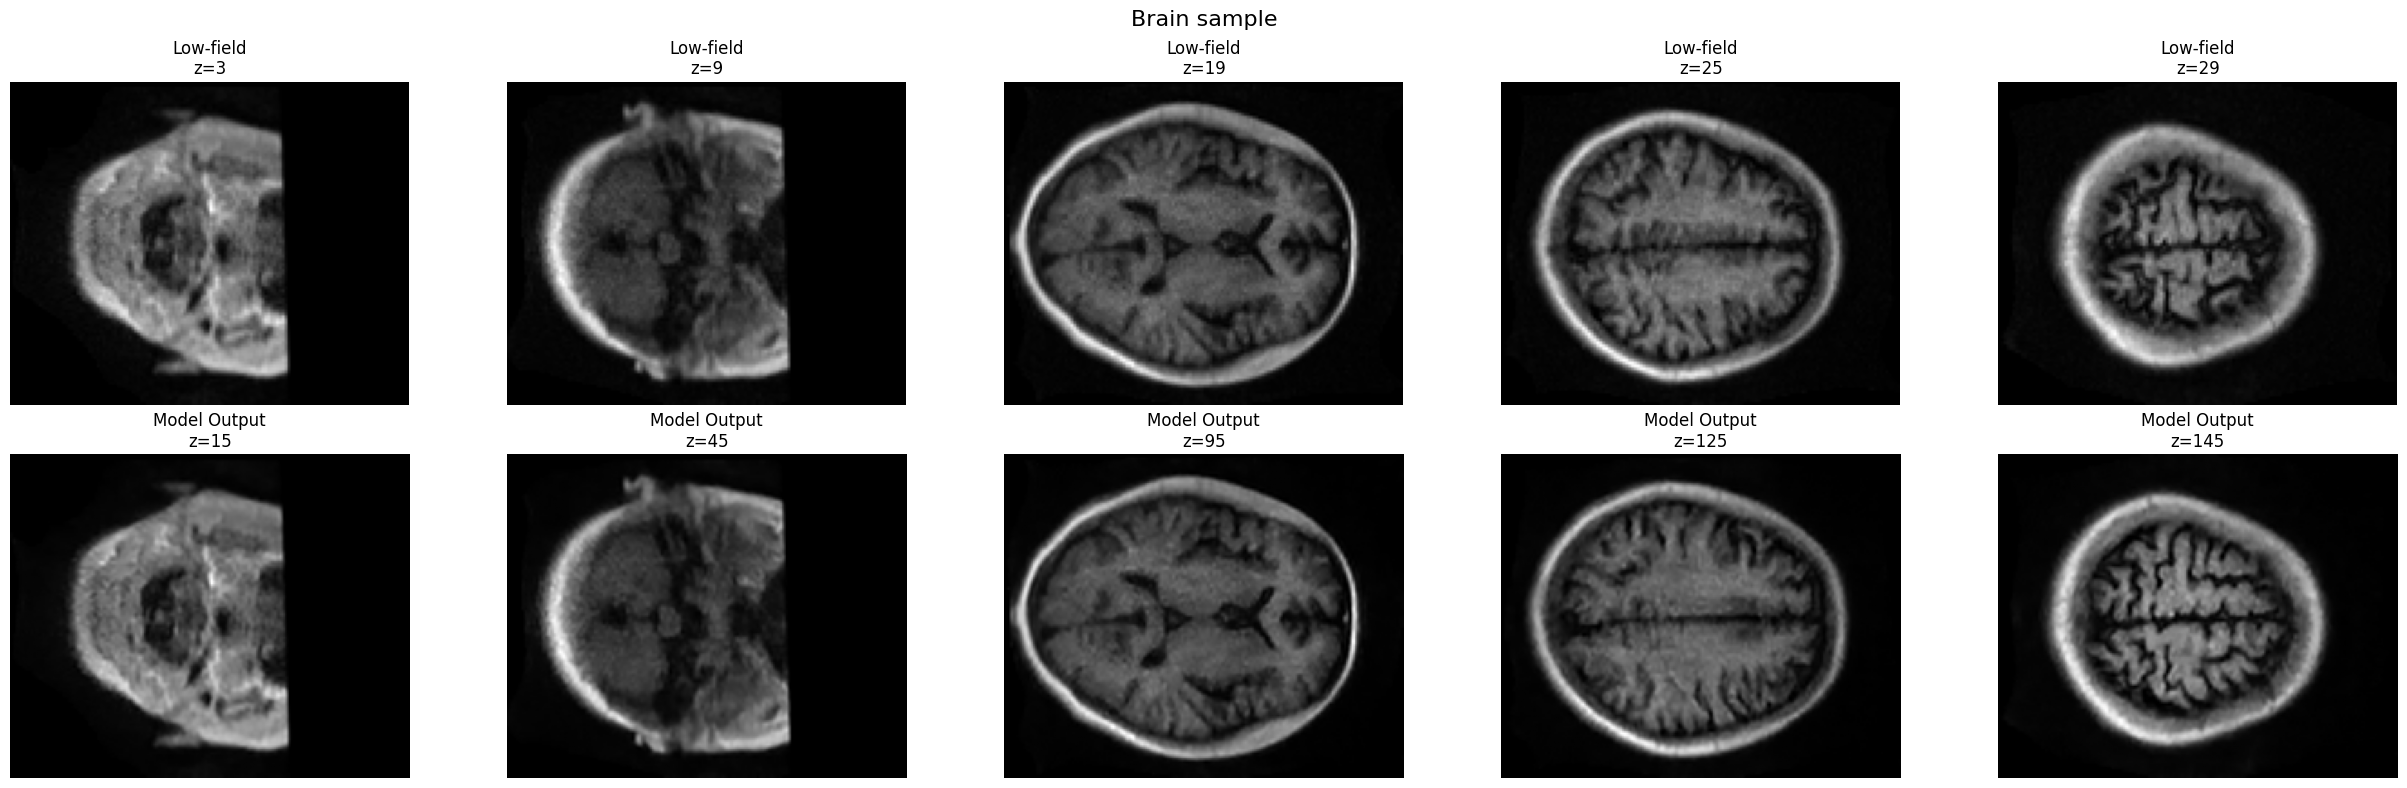

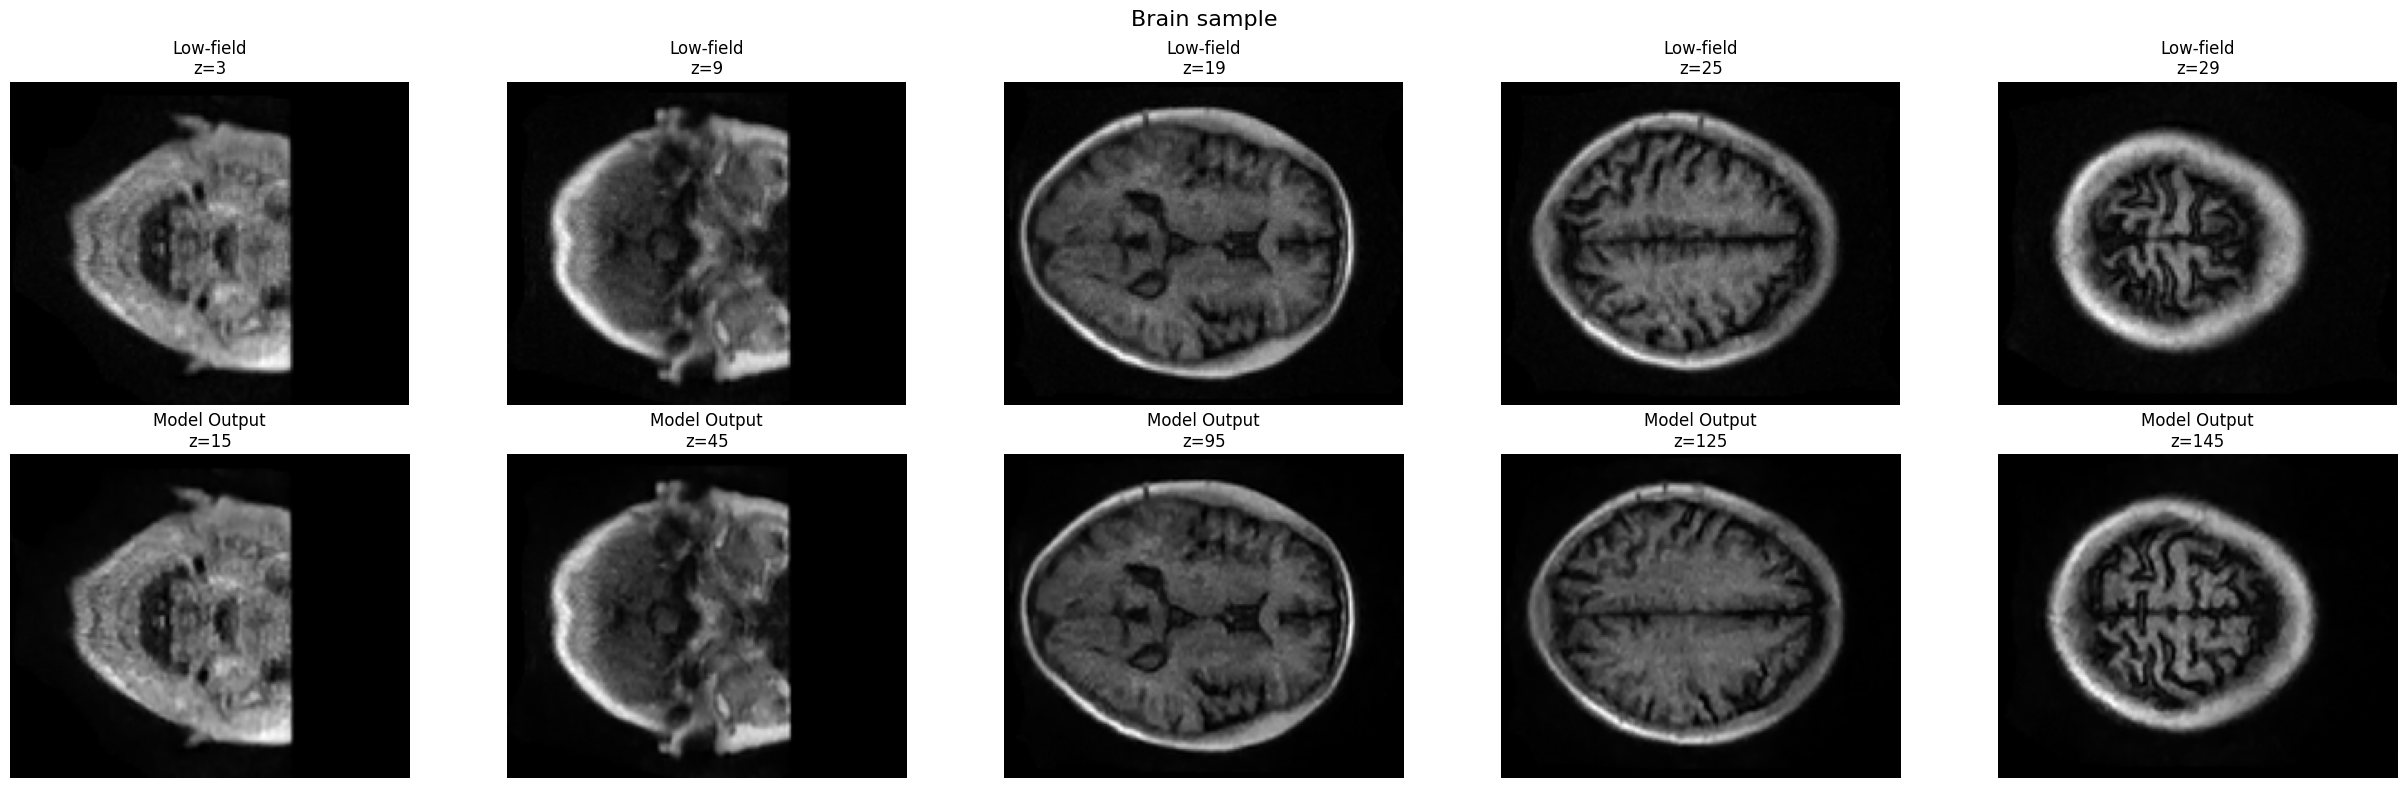

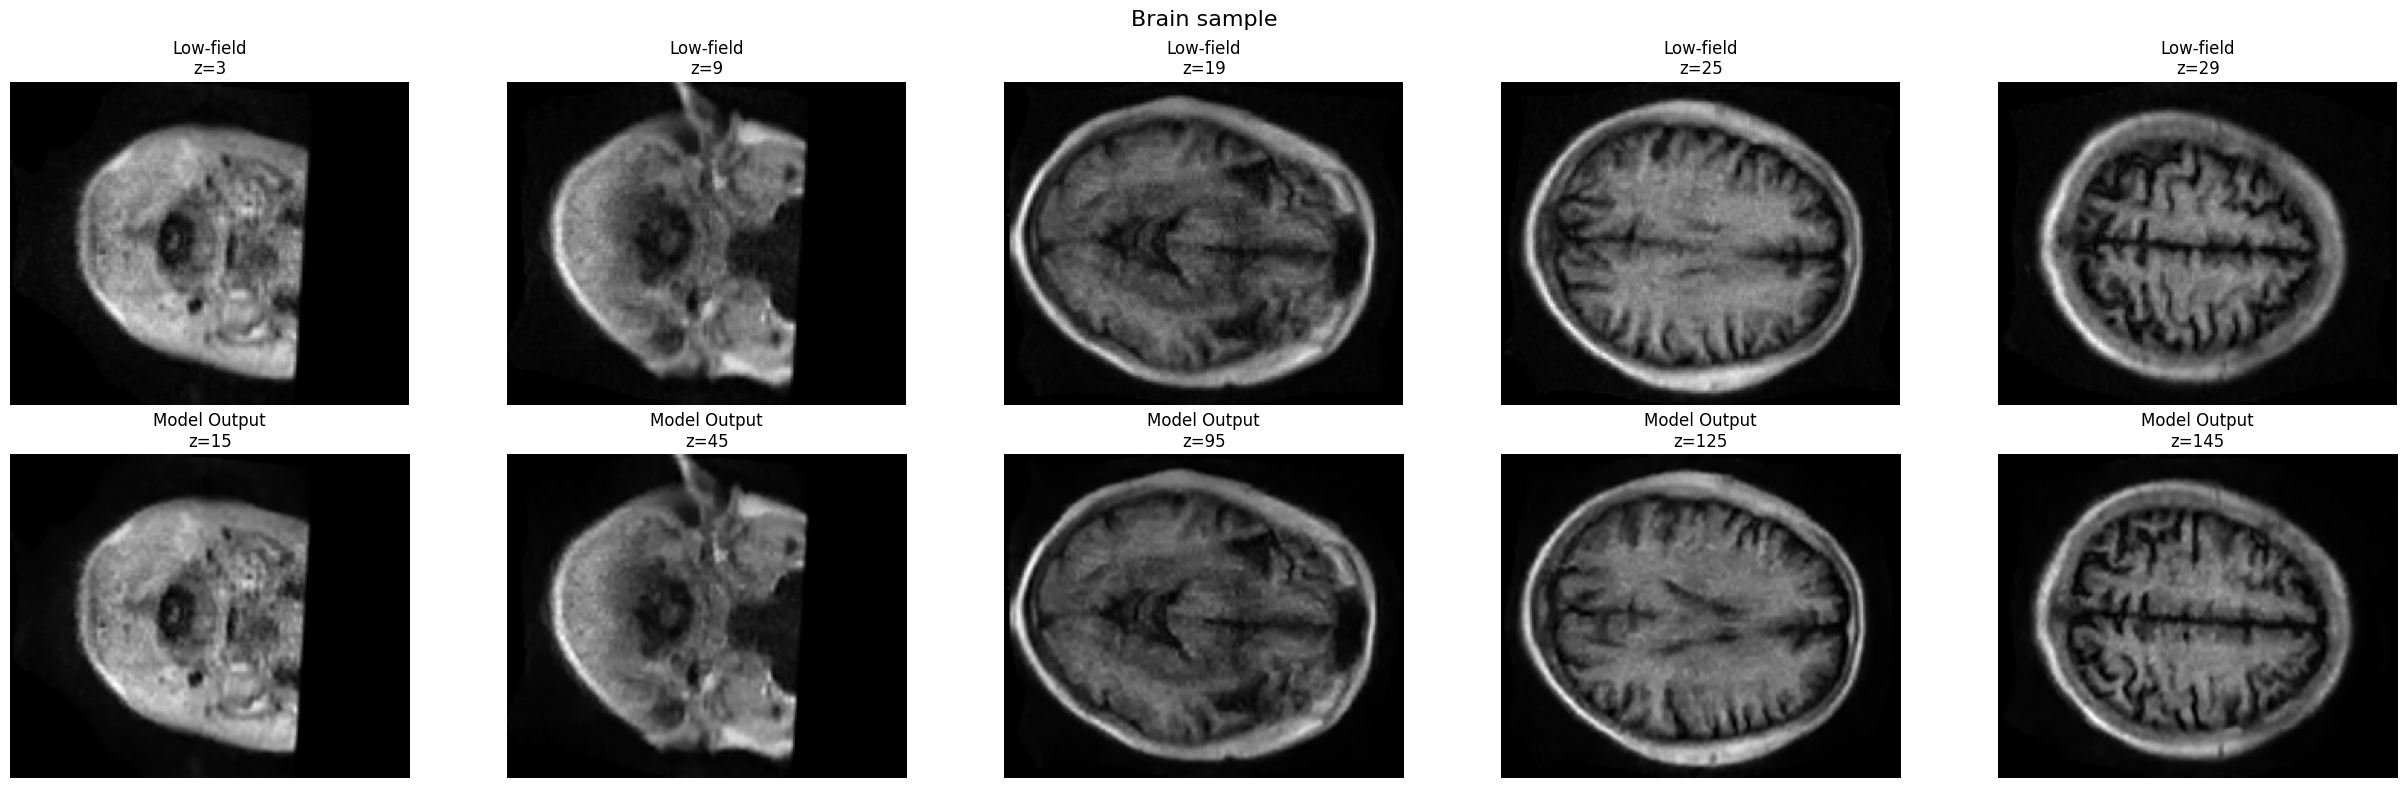

Processing sample_019...
Processing sample_020...
Processing sample_021...
Processing sample_022...
Processing sample_023...

 Submission saved as submission.csv
Total rows: 1000 (should be 1000)


In [17]:

# VISUALIZATION

def plot_fractional_slices_triplet(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(idxs), figsize=(5 * len(idxs), 8))

    for j, z in enumerate(idxs):
        axes[0, j].imshow(low[:, :, z], cmap="gray")
        axes[0, j].set_title(f"Low (z={z})")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, z], cmap="gray")
        axes[1, j].set_title("Model Output")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================
# BASE64 ENCODING
# =========================
def slice_to_base64(slice_2d):
    smin, smax = float(slice_2d.min()), float(slice_2d.max())
    if smax > smin:
        norm = ((slice_2d - smin) / (smax - smin) * 255).astype(np.uint8)
    else:
        norm = np.zeros_like(slice_2d, dtype=np.uint8)

    buf = io.BytesIO()
    np.savez_compressed(buf,
                        slice=norm,
                        shape=slice_2d.shape,
                        min_val=smin,
                        max_val=smax)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

def volume_to_rows(volume, sample_id):
    rows = []
    for z in range(volume.shape[2]):  # now guaranteed 200
        rows.append({
            "row_id": f"{sample_id}_slice_{z:03d}",
            "prediction": slice_to_base64(volume[:, :, z])
        })
    return rows

all_rows = []

nii_files = sorted([
    f for f in os.listdir(LR_NIFTI_DIR)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])

# ---- VISUALIZE SOME SAMPLES ----
def plot_fractional_slices_low_vs_model(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    zp = pred.shape[2]

    low_idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, lz in enumerate(low_idxs):
        pz = int(lz * zp / zl)

        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, pz], cmap="gray")
        axes[1, j].set_title(f"Model Output\nz={pz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

viz_samples = random.sample(nii_files, min(3, len(nii_files)))

for fname in viz_samples:
    sample_id = fname.split("_")[0]
    path = os.path.join(LR_NIFTI_DIR, fname)

    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(model, lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    plot_fractional_slices_low_vs_model(
        low=lr_vol,
        pred=pred_vol,
        brain_id=sample_id,
    )

# ---- CREATE SUBMISSION ----
for fname in nii_files:
    parts = fname.split("_")
    sample_id = f"{parts[0]}_{parts[1]}"
    path = os.path.join(LR_NIFTI_DIR, fname)

    print(f"Processing {sample_id}...")
    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(model, lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    assert pred_vol.shape[2] == TARGET_SLICES

    all_rows.extend(volume_to_rows(pred_vol, sample_id))

df = pd.DataFrame(all_rows)
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n Submission saved as {OUTPUT_CSV}")
print(f"Total rows: {len(df)} (should be {len(nii_files) * TARGET_SLICES})")

In [18]:
model.eval()

# Pick one training pair
lf_path, hf_path = train_data_pair_paths[0]

lr_vol = normalize_mri(load_nii(lf_path))
hr_vol = normalize_mri(load_nii(hf_path))

# Take first slice
k = 0
lr = lr_vol[:, :, k]

z_hr = map_lr_to_hr_slice(
    k,
    lr_vol.shape[2],
    hr_vol.shape[2]
)
hr = hr_vol[:, :, z_hr]

# Convert to tensors
lr_t = torch.tensor(lr, dtype=torch.float32)[None, None].to(device)
hr_t = torch.tensor(hr, dtype=torch.float32)[None, None].to(device)

with torch.no_grad():
    y_up = F.interpolate(
        lr_t,
        size=hr_t.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    x_hat = reconstruct(model, lr_t, out_size=hr_t.shape[-2:])

print("Residual magnitude:", (x_hat - y_up).abs().mean().item())

Residual magnitude: 0.00388064025901258


In [19]:
physics_model = PhysicsUNet().to(device)
physics_model.load_state_dict(torch.load("physics_unet_final.pth"))
physics_model.eval()

for p in physics_model.parameters():
    p.requires_grad = False

In [20]:
residual_model = PhysicsUNet().to(device)

In [21]:
def train_residual():
    dataset = MRINiftiSliceDataset(train_data_pair_paths)

    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    # Load frozen physics model
    physics_model = PhysicsUNet().to(device)
    physics_model.load_state_dict(torch.load("physics_unet_final.pth", map_location=device))
    physics_model.eval()
    for p in physics_model.parameters():
        p.requires_grad = False

    # Residual model
    residual_model = PhysicsUNet().to(device)
    opt = torch.optim.Adam(residual_model.parameters(), lr=1e-4)

    epochs = 120
    for e in range(epochs):
        residual_model.train()
        loss_sum = 0.0

        for y_lr, x_hr in loader:
            y_lr = y_lr.to(device)
            x_hr = x_hr.to(device)

            # Step 1: physics reconstruction
            with torch.no_grad():
                x_phys = reconstruct(
                    physics_model,
                    y_lr,
                    out_size=x_hr.shape[-2:]
                )

            # Step 2: residual target
            residual_gt = x_hr - x_phys

            # Step 3: residual prediction
            r_pred = residual_model(x_phys)

            # Step 4: supervised residual loss
            x_final = x_phys + 0.6 * r_pred

            # residual supervision
            l_res = F.l1_loss(r_pred, residual_gt)

            # weak physics consistency
            l_phys = physics_loss(x_final, y_lr)

            loss = l_res + 0.05 * l_phys

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()

        print(f"Epoch {e+1}/{epochs} | Residual Loss {loss_sum / len(loader):.6f}")

        # Save checkpoint every 10 epochs
        if (e + 1) % 10 == 0:
            current_ckpt = f"residual_unet_{e+1}.pth"
            prev_ckpt = f"residual_unet_{e-9}.pth"

            if os.path.exists(prev_ckpt):
                os.remove(prev_ckpt)
                print(f"Deleted old checkpoint: {prev_ckpt}")

            torch.save(residual_model.state_dict(), current_ckpt)
            print(f"Saved checkpoint: {current_ckpt}")

    # Final save
    rand = random.randint(1000, 9999)
    prev_ckpt = f"residual_unet_{(epochs // 10) * 10}.pth"

    if os.path.exists(prev_ckpt):
        os.remove(prev_ckpt)
        print(f"Deleted old checkpoint: {prev_ckpt}")

    final_path = f"residual_unet_final.pth"
    torch.save(residual_model.state_dict(), final_path)
    print(f"Saved final residual model: {final_path}")

In [23]:
train_residual()

Epoch 1/120 | Residual Loss 0.112056
Epoch 2/120 | Residual Loss 0.098663
Epoch 3/120 | Residual Loss 0.093556
Epoch 4/120 | Residual Loss 0.090082
Epoch 5/120 | Residual Loss 0.088310
Epoch 6/120 | Residual Loss 0.086257
Epoch 7/120 | Residual Loss 0.084354
Epoch 8/120 | Residual Loss 0.083731
Epoch 9/120 | Residual Loss 0.082918
Epoch 10/120 | Residual Loss 0.081538
Saved checkpoint: residual_unet_10.pth
Epoch 11/120 | Residual Loss 0.080445
Epoch 12/120 | Residual Loss 0.079795
Epoch 13/120 | Residual Loss 0.079502
Epoch 14/120 | Residual Loss 0.078777
Epoch 15/120 | Residual Loss 0.078183
Epoch 16/120 | Residual Loss 0.077747
Epoch 17/120 | Residual Loss 0.077440
Epoch 18/120 | Residual Loss 0.076979
Epoch 19/120 | Residual Loss 0.076896
Epoch 20/120 | Residual Loss 0.076422
Deleted old checkpoint: residual_unet_10.pth
Saved checkpoint: residual_unet_20.pth
Epoch 21/120 | Residual Loss 0.075737
Epoch 22/120 | Residual Loss 0.075659
Epoch 23/120 | Residual Loss 0.075305
Epoch 24/120

In [24]:
PHYSICS_MODEL_PATH  = "physics_unet_final.pth"
RESIDUAL_MODEL_PATH = "residual_unet_final.pth"

physics_model = PhysicsUNet().to(device)
physics_model.load_state_dict(torch.load(PHYSICS_MODEL_PATH, map_location=device))
physics_model.eval()

residual_model = PhysicsUNet().to(device)
residual_model.load_state_dict(torch.load(RESIDUAL_MODEL_PATH, map_location=device))
residual_model.eval()

PhysicsUNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )


In [25]:
def ensure_3d(vol):
    if vol.ndim == 4:
        vol = vol[:, :, :, 0]
    return vol

def normalize_volume(vol):
    vmin, vmax = np.percentile(vol, (1, 99))
    vol = np.clip(vol, vmin, vmax)
    return (vol - vmin) / (vmax - vmin + 1e-8)

def load_nifti(path):
    return nib.load(path).get_fdata().astype(np.float32)

def upsample_z_deprecated(volume, target_slices=200):
    """
    volume: (H, W, Z)
    returns: (H, W, target_slices)
    """
    H, W, Z = volume.shape
    zoom_factor = target_slices / Z
    return np.zoom(volume, (1, 1, zoom_factor), order=1)

def upsample_z(volume, target_slices=200):
    H, W, Z = volume.shape
    idxs = np.round(
        np.linspace(0, Z - 1, target_slices)
    ).astype(int)
    return volume[:, :, idxs]

def mild_sharpen(x):
    blur = gaussian_filter(x, sigma=0.6)
    return np.clip(x + 0.15 * (x - blur), 0, 1)

# =========================
# MODEL RECONSTRUCTION
# =========================
TARGET_SIZE = (179, 221)

def reconstruct_slice(physics_model, residual_model, lr_slice):
    x = torch.from_numpy(lr_slice)[None, None].float().to(device)

    with torch.no_grad():
        # Stage 1: physics reconstruction to HR size
        x_phys = reconstruct(
            physics_model,
            x,
            out_size=TARGET_SIZE
        )

        # Stage 2: residual refinement
        r_pred = residual_model(x_phys)

        # Final output (with scaling if you use it)
        x_final = x_phys + 0.3805 * r_pred

    return x_final.squeeze().cpu().numpy()

def reconstruct_volume(physics_model, residual_model, lr_vol):
    slices = []
    for z in range(lr_vol.shape[2]):
        slices.append(
            reconstruct_slice(
                physics_model,
                residual_model,
                lr_vol[:, :, z]
            )
        )
    return np.stack(slices, axis=2)

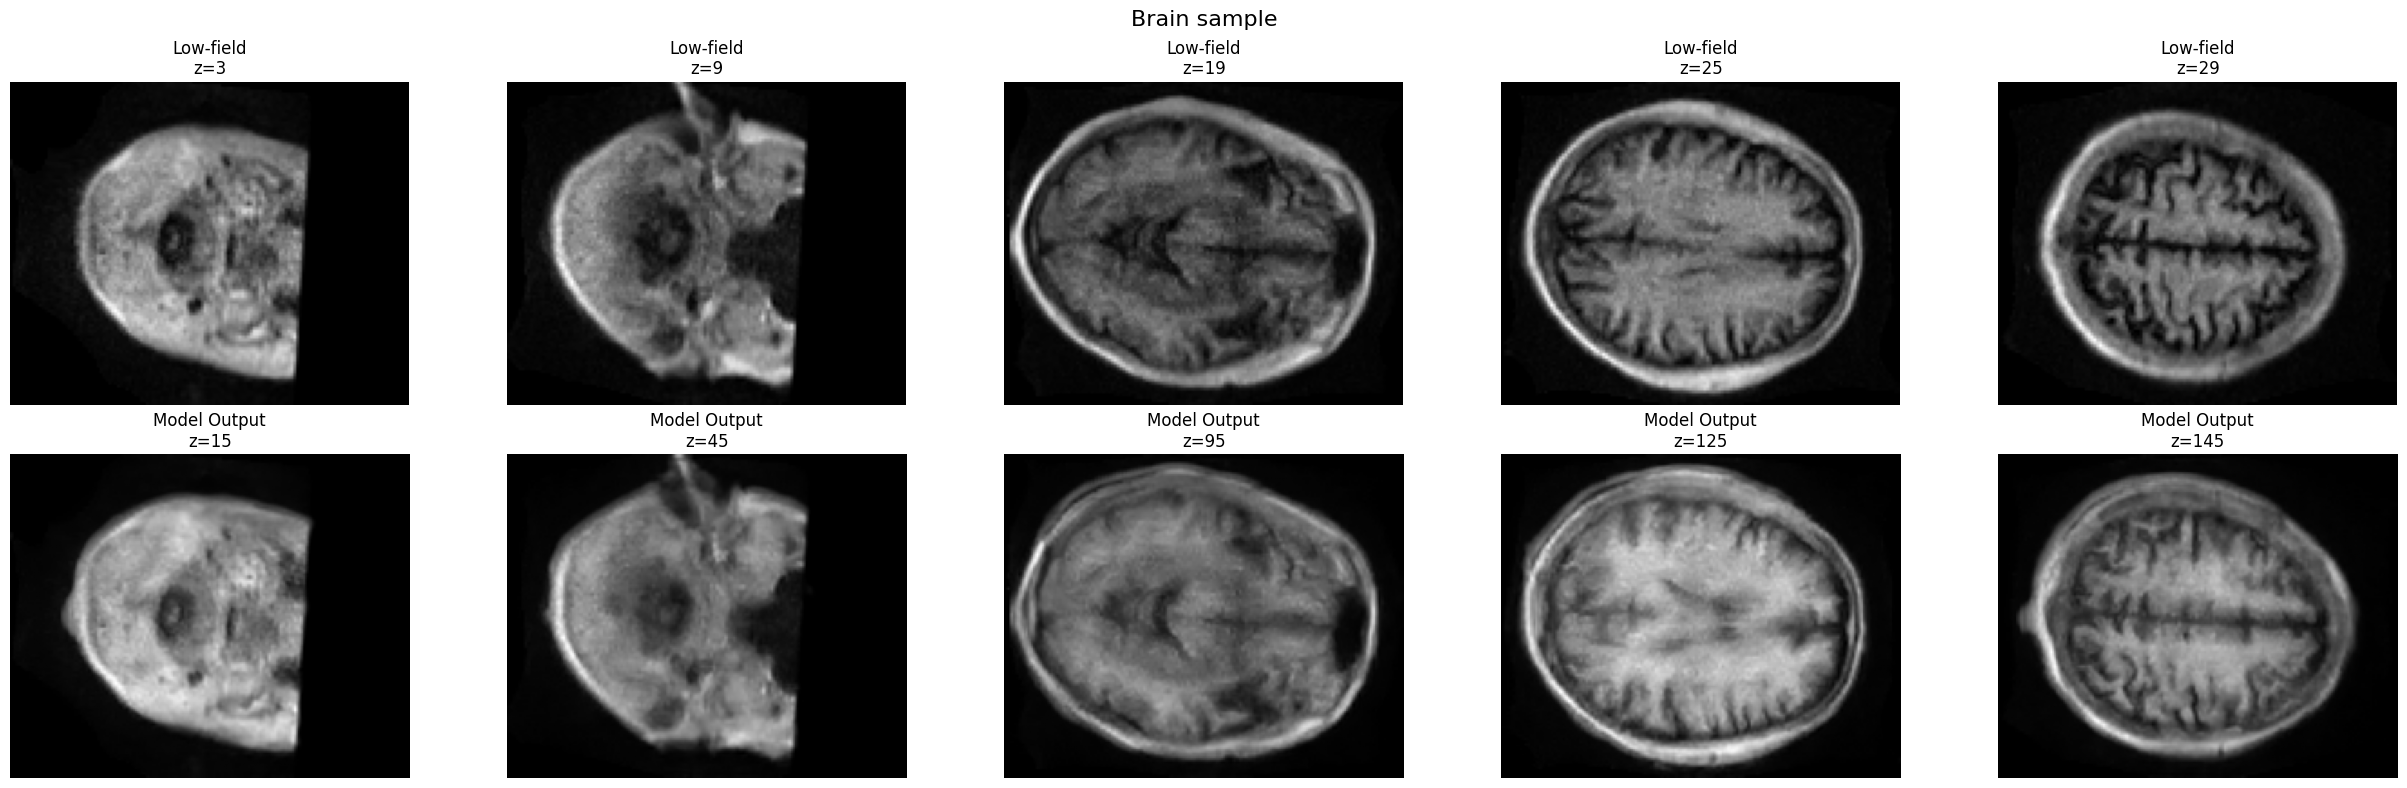

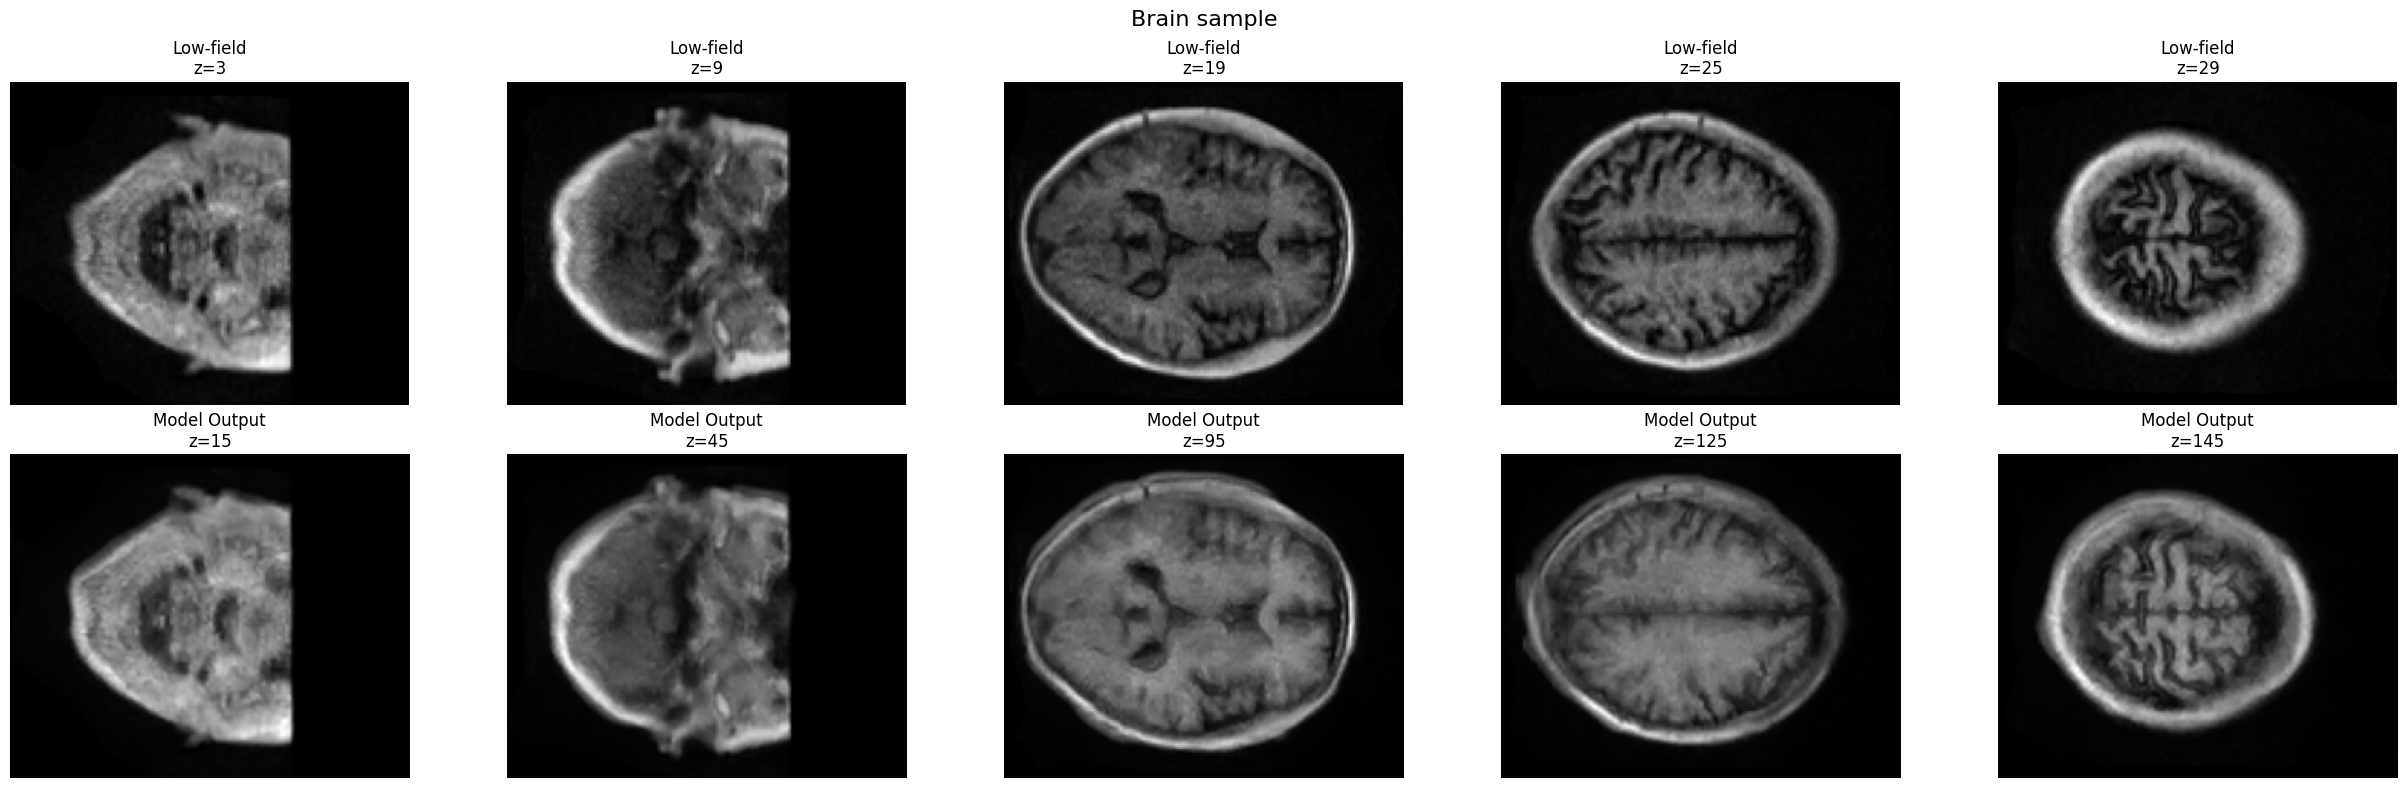

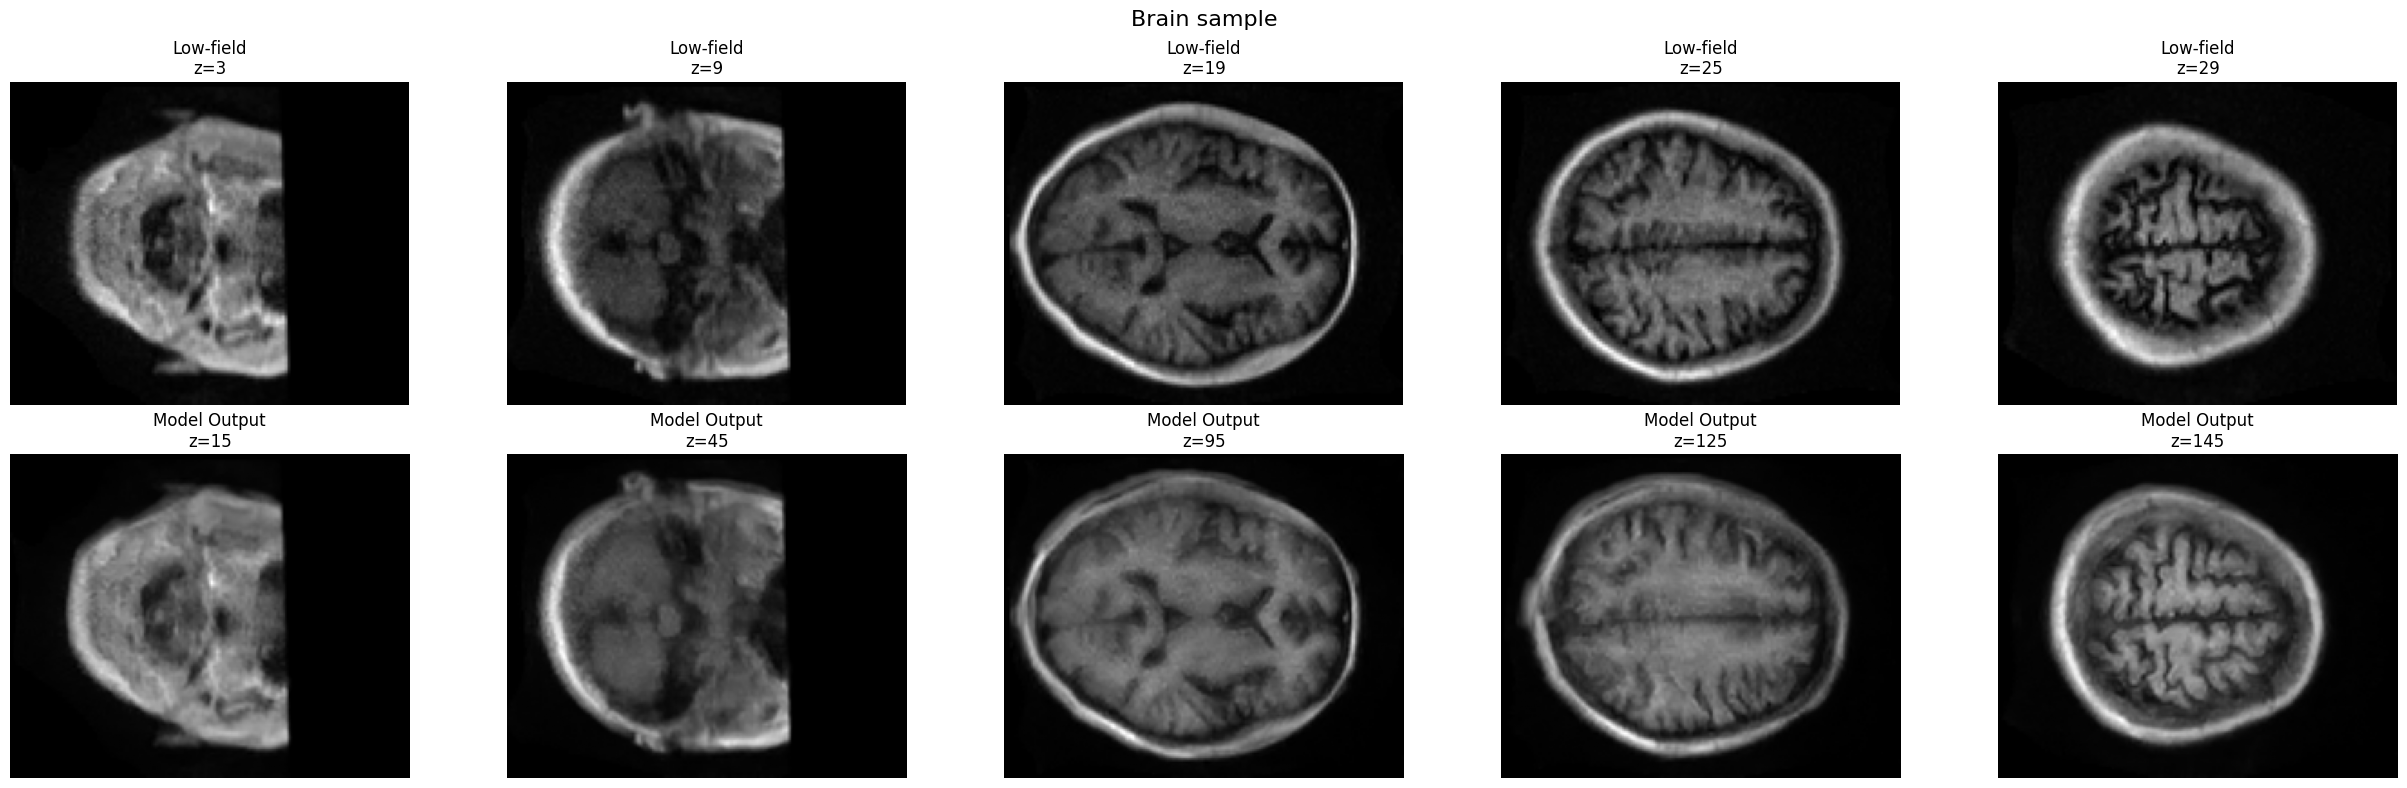

Processing sample_019...
(179, 221, 200)
Processing sample_020...
(179, 221, 200)
Processing sample_021...
(179, 221, 200)
Processing sample_022...
(179, 221, 200)
Processing sample_023...
(179, 221, 200)

 Submission saved as submission.csv
Total rows: 1000 (should be 1000)


In [26]:

# VISUALIZATION

def plot_fractional_slices_triplet(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(idxs), figsize=(5 * len(idxs), 8))

    for j, z in enumerate(idxs):
        axes[0, j].imshow(low[:, :, z], cmap="gray")
        axes[0, j].set_title(f"Low (z={z})")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, z], cmap="gray")
        axes[1, j].set_title("Model Output")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================
# BASE64 ENCODING
# =========================
def slice_to_base64(slice_2d):
    smin, smax = float(slice_2d.min()), float(slice_2d.max())
    if smax > smin:
        norm = ((slice_2d - smin) / (smax - smin) * 255).astype(np.uint8)
    else:
        norm = np.zeros_like(slice_2d, dtype=np.uint8)

    buf = io.BytesIO()
    np.savez_compressed(buf,
                        slice=norm,
                        shape=slice_2d.shape,
                        min_val=smin,
                        max_val=smax)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

def volume_to_rows(volume, sample_id):
    rows = []
    for z in range(volume.shape[2]):  # now guaranteed 200
        rows.append({
            "row_id": f"{sample_id}_slice_{z:03d}",
            "prediction": slice_to_base64(volume[:, :, z])
        })
    return rows

all_rows = []

nii_files = sorted([
    f for f in os.listdir(LR_NIFTI_DIR)
    if f.endswith(".nii") or f.endswith(".nii.gz")
])

# ---- VISUALIZE SOME SAMPLES ----
def plot_fractional_slices_low_vs_model(
    low,
    pred,
    brain_id,
    fractions=(0.1, 0.25, 0.5, 0.66, 0.75)
):
    low = ensure_3d(low)
    pred = ensure_3d(pred)

    zl = low.shape[2]
    zp = pred.shape[2]

    low_idxs = [int(f * (zl - 1)) for f in fractions]

    fig, axes = plt.subplots(2, len(fractions), figsize=(5 * len(fractions), 8))

    for j, lz in enumerate(low_idxs):
        pz = int(lz * zp / zl)

        axes[0, j].imshow(low[:, :, lz], cmap="gray")
        axes[0, j].set_title(f"Low-field\nz={lz}")
        axes[0, j].axis("off")

        axes[1, j].imshow(pred[:, :, pz], cmap="gray")
        axes[1, j].set_title(f"Model Output\nz={pz}")
        axes[1, j].axis("off")

    fig.suptitle(f"Brain {brain_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

viz_samples = random.sample(nii_files, min(3, len(nii_files)))

for fname in viz_samples:
    sample_id = fname.split("_")[0]
    path = os.path.join(LR_NIFTI_DIR, fname)

    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(
        physics_model,
        residual_model,
        lr_vol
    )

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    plot_fractional_slices_low_vs_model(
        low=lr_vol,
        pred=pred_vol,
        brain_id=sample_id,
    )

# ---- CREATE SUBMISSION ----
for fname in nii_files:
    parts = fname.split("_")
    sample_id = f"{parts[0]}_{parts[1]}"
    path = os.path.join(LR_NIFTI_DIR, fname)

    print(f"Processing {sample_id}...")
    # lr_vol = normalize_volume(load_nifti(path))
    lr_vol = load_nifti(path)
    lr_vol = (lr_vol - lr_vol.min()) / (lr_vol.max() - lr_vol.min() + 1e-8)
    pred_vol = reconstruct_volume(physics_model,
        residual_model,
        lr_vol)

    if pred_vol.shape[2] != TARGET_SLICES:
        pred_vol = upsample_z(pred_vol, TARGET_SLICES)
        pred_vol = mild_sharpen(pred_vol)

    assert pred_vol.shape[2] == TARGET_SLICES
    print(pred_vol.shape)

    all_rows.extend(volume_to_rows(pred_vol, sample_id))

df = pd.DataFrame(all_rows)
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n Submission saved as {OUTPUT_CSV}")
print(f"Total rows: {len(df)} (should be {len(nii_files) * TARGET_SLICES})")